In [1]:
%cd ..

/mnt/ceph/users/zzhang/CRISPR_pred/crispr_kinn


In [2]:
import tensorflow as tf
import h5py
import numpy as np
import pandas as pd
import os
import scipy.stats as ss
import src
from src.transfer_learn import KinnLayer, amber_app
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
%matplotlib inline
from tqdm import tqdm
from sklearn.metrics import average_precision_score
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

Using TensorFlow backend.


In [3]:
with h5py.File("./data/inVivoData.newValidSplit.h5", "r") as store:
    t1 = store["test/Kleinsitver_mut/x"][()], store["test/Kleinsitver_mut/y"][()]
    t2 = store["test/Listgarten_mut/x"][()], store["test/Listgarten_mut/y"][()]
    t3 = store["test/Listgarten_indel/x"][()], store["test/Listgarten_indel/y"][()]
    valid_data = store["valid/x"][()], store["valid/y"][()]

In [4]:
target_wds = [f"outputs/2022-11-01/TL_{i}" for i in (1,2,3,4,5)]
target_wds

['outputs/2022-11-01/TL_1',
 'outputs/2022-11-01/TL_2',
 'outputs/2022-11-01/TL_3',
 'outputs/2022-11-01/TL_4',
 'outputs/2022-11-01/TL_5']

In [5]:
def load_model_and_benchmark(amb, wd, arc_seq, return_preds=False):
    tf.reset_default_graph()
    train_graph = tf.Graph()
    train_sess = tf.Session(graph=train_graph)
    with train_graph.as_default(), train_sess.as_default():
        model = amb.model_fn(arc_seq)
        model.load_weights(os.path.join(wd, "bestmodel.h5"))
        benchmarks = {
            "Kleinsitver": model.predict(t1[0], batch_size=25000).flatten() if return_preds else amb.reward_fn(model, t1)[0],
            "Listgarten": model.predict(t2[0], batch_size=25000).flatten() if return_preds else amb.reward_fn(model, t2)[0],
            "Listgarten_Indel": model.predict(t3[0], batch_size=25000).flatten() if return_preds else amb.reward_fn(model, t3)[0],
            "Valid": model.predict(valid_data[0], batch_size=25000).flatten() if return_preds else amb.reward_fn(model, valid_data)[0],
        }
    tf.keras.backend.clear_session()
    return benchmarks

def load_model_ensemble_predict(amb, arc_wd_pairs, verbose=True):
    preds = {}
    pbar = tqdm(arc_wd_pairs) if verbose else arc_wd_pairs
    for arc, wd in pbar:
        pred = load_model_and_benchmark(amb, wd, arc, return_preds=True)
        preds[wd] = pred
    return preds

def ensemble_benchmark(ensemble_preds, verbose=False):
    preds = {}
    label_dict = {"Kleinsitver": t1[1], "Listgarten": t2[1], "Listgarten_Indel": t3[1], "Valid": valid_data[1]}
    pbar = tqdm(ensemble_preds) if verbose else ensemble_preds
    for cls in pbar:
        if verbose: pbar.set_description(cls)
        for ds in ensemble_preds[cls]:
            if ds in preds:
                preds[ds].append(ensemble_preds[cls][ds])
            else:
                preds[ds] = [ensemble_preds[cls][ds]]
    benchmarks = {}
    for ds in preds:
        y_score = np.array(preds[ds]).mean(axis=0)
        benchmarks[ds] = average_precision_score(label_dict[ds], y_score)
    return benchmarks

In [6]:
if os.path.isdir("weights"):
    os.rmdir("weights")
amb = amber_app(wd=".", run=False)
# clean up folders created by trainEnv
os.rmdir("weights")

BUILDING
----------


2023-10-20 16:28:37,400 - AMBER - INFO -
 time budget set to: 72:00:00


controller = GeneralController
modeler = <class 'src.transfer_learn.TransferKinnModelBuilder'>
knowledge = zero
reward = LossAucReward
manager = GeneralManager
env_type = ControllerTrainEnv


In [7]:
# optionally, load model space from disk
%run src/transfer_learn
with open(os.path.join(target_wds[0], "model_space.pkl"), "rb") as f:
    model_space, _ = pickle.load(f)
amb.model_fn.model_space = model_space
amb.model_space = model_space

In [8]:
print("total model space size: %i"%np.prod([len(x) for x in amb.model_space]))

total model space size: 10368


In [9]:
bm_df = []
n_tail = 25
for target_wd in target_wds:
    train_hist = pd.read_table(os.path.join(target_wd, "train_history.csv"), sep=",", header=None)
    # we take the last n_tail arcs from amber search because amber accounts for arc variances
    for i in tqdm(train_hist.tail(n_tail).index):
    # we don't sort train_hist by valid b/c its prone to random init, instead of good arcs
    #for i in tqdm(train_hist.sort_values(2).tail(n_tail).index):
        trial_id = train_hist.loc[i, 0]
        arc_seq = train_hist.loc[i, 3:].tolist()
        #print(i, trial_id, arc_seq)
        wd = os.path.join(target_wd, "weights", "trial_%i"%trial_id)
        benchmarks = load_model_and_benchmark(amb=amb, wd=wd, arc_seq=arc_seq)
        benchmarks.update({
            'arc': arc_seq,
            'Valid_amber': train_hist.loc[i, 2],
            'trial': trial_id,
            'wd': target_wd, #'_'.join(target_wd.split('/')[1:]),
        })
        bm_df.append(benchmarks)

100%|██████████| 25/25 [04:46<00:00, 11.46s/it]


In [10]:
bm_df = pd.DataFrame(bm_df)

In [11]:
bm_df = bm_df.sort_values('Valid', ascending=False)
bm_df.head(20)

,Kleinsitver,Listgarten,Listgarten_Indel,Valid,arc,Valid_amber,trial,wd
105,0.188933,0.140707,0.208201,0.437008,"[0, 1, 5, 0, 0, 0, 1]",0.437008,480,outputs/2022-11-01/TL_5
122,0.201541,0.127623,0.269383,0.431985,"[0, 2, 5, 0, 0, 0, 1]",0.431985,497,outputs/2022-11-01/TL_5
69,0.286501,0.187777,0.303858,0.417972,"[0, 2, 5, 0, 0, 0, 5]",0.417972,494,outputs/2022-11-01/TL_3
123,0.306120,0.167297,0.348041,0.415541,"[0, 1, 5, 0, 0, 0, 5]",0.415541,498,outputs/2022-11-01/TL_5
34,0.241852,0.122252,0.247362,0.408659,"[1, 1, 5, 1, 1, 0, 5]",0.408659,484,outputs/2022-11-01/TL_2
19,0.224744,0.126572,0.146200,0.408633,"[1, 2, 5, 0, 1, 0, 1]",0.408633,494,outputs/2022-11-01/TL_1
42,0.239877,0.140719,0.248741,0.407710,"[1, 2, 1, 1, 1, 0, 5]",0.407709,492,outputs/2022-11-01/TL_2
21,0.223104,0.081191,0.133428,0.403100,"[1, 2, 5, 0, 1, 0, 1]",0.403100,496,outputs/2022-11-01/TL_1
81,0.186315,0.119433,0.171315,0.402455,"[0, 1, 1, 2, 1, 0, 3]",0.402455,481,outputs/2022-11-01/TL_4
24,0.219843,0.137375,0.111607,0.402050,"[1, 2, 5, 0, 1, 0, 1]",0.402050,499,outputs/2022-11-01/TL_1


Text(0.5, 1.0, 'spm=1.000')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'serif' not found because none of the following families were found: Times New Roman


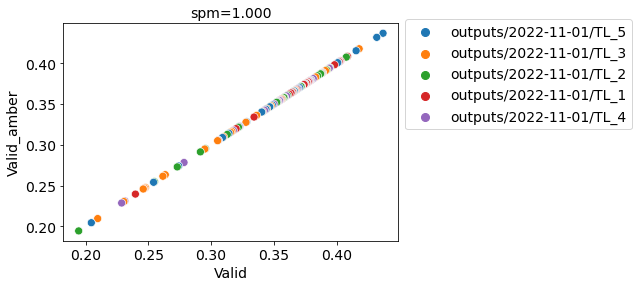

In [12]:
ax = sns.scatterplot(x='Valid', y='Valid_amber', data=bm_df, hue='wd')
ax.legend(loc='upper left', bbox_to_anchor=(1,1.05))
ax.set_title("spm=%.3f"%ss.spearmanr(bm_df['Valid'], bm_df['Valid_amber']).correlation)

In [13]:
bm_df[['Kleinsitver', 'Listgarten', 'Listgarten_Indel', 'Valid']].corr()

,Kleinsitver,Listgarten,Listgarten_Indel,Valid
Kleinsitver,1.000000,0.667664,0.263211,0.497097
Listgarten,0.667664,1.000000,0.456013,0.564018
Listgarten_Indel,0.263211,0.456013,1.000000,0.125710
Valid,0.497097,0.564018,0.125710,1.000000


Text(0.5, 1.0, 'spm=0.468')

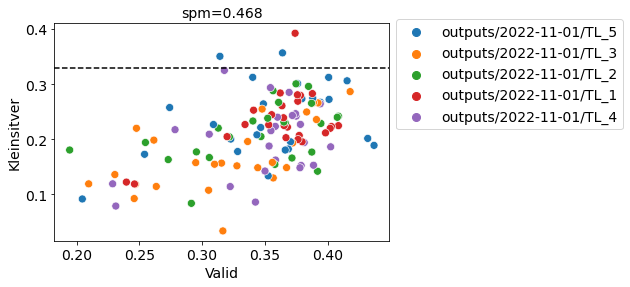

In [14]:
ax = sns.scatterplot(x='Valid', y='Kleinsitver', data=bm_df, hue='wd')
ax.legend(loc='upper left', bbox_to_anchor=(1,1.05))
ax.axhline(y=0.329, ls='--', color='k')
ax.set_title("spm=%.3f"%ss.spearmanr(bm_df['Valid'], bm_df['Kleinsitver']).correlation)

Text(0.5, 1.0, 'spm=0.534')

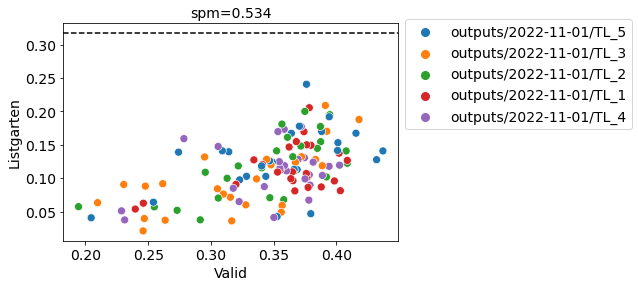

In [15]:
ax=sns.scatterplot(x='Valid', y='Listgarten', data=bm_df, hue='wd')
ax.axhline(y=0.317, ls='--', color='k')
ax.legend(loc='upper left', bbox_to_anchor=(1,1.05))
ax.set_title("spm=%.3f"%ss.spearmanr(bm_df['Valid'], bm_df['Listgarten']).correlation)

Text(0.5, 1.0, 'spm=0.112')

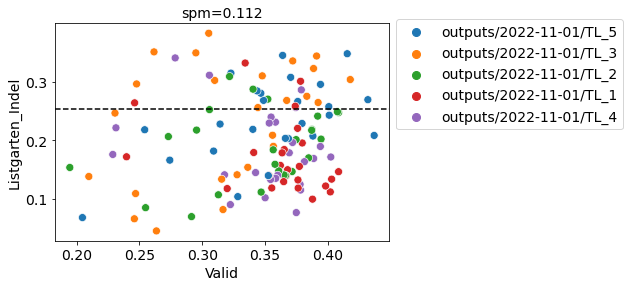

In [16]:
ax=sns.scatterplot(x='Valid', y='Listgarten_Indel', data=bm_df, hue='wd')
ax.axhline(y=0.254, ls='--', color='k')
ax.legend(loc='upper left', bbox_to_anchor=(1,1.05))
ax.set_title("spm=%.3f"%ss.spearmanr(bm_df['Valid'], bm_df['Listgarten_Indel']).correlation)

In [17]:
n_max_models_per_run = 1
bm_df_ = pd.concat([df.sort_values('Valid').tail(n_max_models_per_run) for _, df in bm_df.groupby('wd')]).sort_values('Valid', ascending=False)
bm_df = bm_df_

In [18]:
bm_df

,Kleinsitver,Listgarten,Listgarten_Indel,Valid,arc,Valid_amber,trial,wd
105,0.188933,0.140707,0.208201,0.437008,"[0, 1, 5, 0, 0, 0, 1]",0.437008,480,outputs/2022-11-01/TL_5
69,0.286501,0.187777,0.303858,0.417972,"[0, 2, 5, 0, 0, 0, 5]",0.417972,494,outputs/2022-11-01/TL_3
34,0.241852,0.122252,0.247362,0.408659,"[1, 1, 5, 1, 1, 0, 5]",0.408659,484,outputs/2022-11-01/TL_2
19,0.224744,0.126572,0.146200,0.408633,"[1, 2, 5, 0, 1, 0, 1]",0.408633,494,outputs/2022-11-01/TL_1
81,0.186315,0.119433,0.171315,0.402455,"[0, 1, 1, 2, 1, 0, 3]",0.402455,481,outputs/2022-11-01/TL_4


In [19]:
arc_wd_pairs = [
    (row['arc'], os.path.join(row['wd'], 'weights', 'trial_%i'%row['trial']))  
    for _, row in bm_df.iterrows()
]
ensemble_preds = load_model_ensemble_predict(amb, arc_wd_pairs, verbose=True)

100%|██████████| 5/5 [00:51<00:00, 10.33s/it]


In [20]:
tmp = {}
incremental_benchmark = []
n_max_models = 10
cnter = {'add':0, 'remove':0}
seen_wd = set()
# forward selection based on Valid
for step, cls in enumerate(ensemble_preds):
    if bm_df.iloc[step]['wd'] in seen_wd:
        continue
    tmp.update({cls:ensemble_preds[cls]})
    res = ensemble_benchmark(tmp)
    res.update({
        'step':step, 
        'n_models': len(tmp), 
        'indv_perform': bm_df.iloc[step][['Kleinsitver', 'Listgarten', 'Listgarten_Indel']].astype(float).round(3).tolist(),
        'arc': bm_df.iloc[step]['arc'],
        'trial': bm_df.iloc[step]['trial'],
        'wd': bm_df.iloc[step]['wd'],        
    })
    if 1: #len(incremental_benchmark)==0 or res['Valid'] > incremental_benchmark[-1]['Valid']:
        incremental_benchmark.append(res)
        cnter['add'] += 1
        seen_wd.add(bm_df.iloc[step]['wd'])
    else:
        del tmp[cls]
        cnter['remove'] += 1
    if len(tmp) >= n_max_models:
        print("break due to max models")
        break
cnter

{'add': 5, 'remove': 0}

In [21]:
seen_wd

{'outputs/2022-11-01/TL_1',
 'outputs/2022-11-01/TL_2',
 'outputs/2022-11-01/TL_3',
 'outputs/2022-11-01/TL_4',
 'outputs/2022-11-01/TL_5'}

In [22]:
incremental_benchmark_df = pd.DataFrame(incremental_benchmark, index=np.arange(len(incremental_benchmark)))

incremental_benchmark_df.to_csv("./outputs/analysis/transfer_learn.incremental_benchmark.tsv", sep="\t", index=False)
incremental_benchmark_df

,Kleinsitver,Listgarten,Listgarten_Indel,Valid,step,n_models,indv_perform,arc,trial,wd
0,0.188933,0.140707,0.208201,0.437008,0,1,"[0.189, 0.141, 0.208]","[0, 1, 5, 0, 0, 0, 1]",480,outputs/2022-11-01/TL_5
1,0.324715,0.195480,0.278344,0.439493,1,2,"[0.287, 0.188, 0.304]","[0, 2, 5, 0, 0, 0, 5]",494,outputs/2022-11-01/TL_3
2,0.316479,0.228706,0.352824,0.442244,2,3,"[0.242, 0.122, 0.247]","[1, 1, 5, 1, 1, 0, 5]",484,outputs/2022-11-01/TL_2
3,0.325627,0.222703,0.301412,0.442706,3,4,"[0.225, 0.127, 0.146]","[1, 2, 5, 0, 1, 0, 1]",494,outputs/2022-11-01/TL_1
4,0.364205,0.261566,0.324285,0.445176,4,5,"[0.186, 0.119, 0.171]","[0, 1, 1, 2, 1, 0, 3]",481,outputs/2022-11-01/TL_4


(0.1, 0.5)

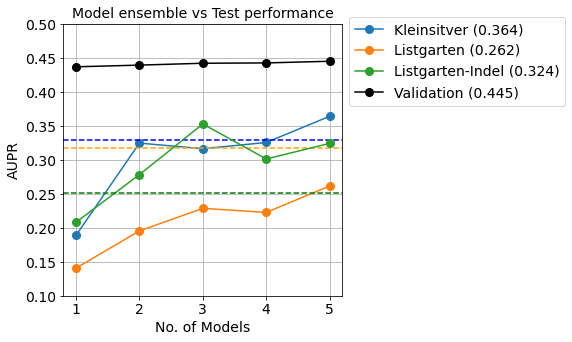

In [25]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.grid()
ax.plot(incremental_benchmark_df['n_models'], incremental_benchmark_df['Kleinsitver'], marker='o', 
        label='Kleinsitver (%.3f)' % incremental_benchmark_df.tail(1)['Kleinsitver'])
ax.axhline(y=0.329, ls='--', color='blue')

ax.plot(incremental_benchmark_df['n_models'], incremental_benchmark_df['Listgarten'], marker='o', 
        label='Listgarten (%.3f)' % incremental_benchmark_df.tail(1)['Listgarten'])
ax.axhline(y=0.317, ls='--', color='orange')

ax.plot(incremental_benchmark_df['n_models'], incremental_benchmark_df['Listgarten_Indel'], marker='o', 
        label='Listgarten-Indel (%.3f)' % incremental_benchmark_df.tail(1)['Listgarten_Indel'])
ax.axhline(y=0.252, ls='--', color='green')

ax.plot(incremental_benchmark_df['n_models'], incremental_benchmark_df['Valid'], marker='o', 
        label='Validation (%.3f)' % incremental_benchmark_df.tail(1)['Valid'], c='k')

ax.legend(loc='upper left', bbox_to_anchor=(1, 1.05))
ax.set_title("Model ensemble vs Test performance")
ax.set_xlabel('No. of Models')
ax.set_ylabel('AUPR')
ax.set_ylim(0.1,0.5)

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Fri Oct 20 2023

Python implementation: CPython
Python version       : 3.7.9
IPython version      : 7.22.0

src       : 0.0.3
matplotlib: 3.4.3
argparse  : 1.1
scipy     : 1.7.3
seaborn   : 0.11.1
numpy     : 1.19.5
pandas    : 1.0.3
tensorflow: 1.15.0
h5py      : 2.10.0

Watermark: 2.3.1

